In [1]:
# !pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import isodate
import scipy.stats as st
from googleapiclient.discovery import build
from api_keys import api_key

In [3]:
# Reading in the datafile
cleaned_us_data_df = pd.read_csv('output/cleaned_us_data.csv')

In [4]:
# Obtaining the unique video_ids to use in the API call
unique_video_id_list = cleaned_us_data_df.drop_duplicates(subset=['video_id'])
unique_video_id_list = unique_video_id_list['video_id']

# Saving it to a dataframe so I can put the video_ids into a list format
unique_video_id_list_df = pd.DataFrame(unique_video_id_list)

# Creating a list of the video_id's to use in the API call
unique_video_id_list = unique_video_id_list_df['video_id'].tolist()

In [5]:
# Running the youtube API and pulling back the video_id and duration
API_KEY = api_key
channel_id = "UC8JOgFXp-I3YV6dsKqqQdUw"
youtube = build('youtube', 'v3', developerKey=API_KEY)

stats_list=[]
    
for i in range(0, len(unique_video_id_list), 50):
    request = youtube.videos().list(
    part="snippet,contentDetails,statistics",
    id=unique_video_id_list[i:i+50]
    )
    
    try:
        data = request.execute()
 
        for video in data['items']:
            video_id = video['id']
            duration = (video['contentDetails']['duration'])
            stats_dictionary = dict(video_id=video_id, duration=''.join(duration))
            stats_list.append(stats_dictionary)
    
    except:
        pass

# Saving output to dataframe and a csv file
video_length_df = pd.DataFrame(stats_list)
video_length_csv = video_length_df.to_csv('output/video_length.csv', index=False, header=True)

In [32]:
# Read in csv file and checking file
video_length_df = pd.read_csv('output/video_length.csv')
video_length_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5798 entries, 0 to 5797
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   video_id  5798 non-null   object
 1   duration  5798 non-null   object
dtypes: object(2)
memory usage: 90.7+ KB


In [34]:
# Merging the duration data into the main data file
duration_data_df = pd.merge(cleaned_us_data_df, video_length_df, on='video_id',how='left')

In [35]:
# Dropping rows that do not have a youtube duration
duration_data_df = duration_data_df.dropna(how='any', subset=['duration'])

In [37]:
# Converting youtube video duration into seconds
duration_seconds_list = []

for video in duration_data_df['duration']:
    dur = isodate.parse_duration(video)
    dur_seconds = dur.total_seconds()
    duration_seconds_list.append(dur_seconds)

# Saving it to a column in the dataframe
duration_data_df['duration_seconds'] = duration_seconds_list

In [38]:
# Filtering rows so we only get the lastest trending date row for each video

# Changing trending_date to date format it can be sorted by date
unique_video_id_duration = pd.to_datetime(duration_data_df['trending_date'], format='%y.%d.%m')

# Sorting the dataframe by trending_date in ascending order
unique_video_id_duration = duration_data_df.sort_values(by='trending_date', ascending=True)

# Taking the last row for each video_id
unique_video_id_duration = duration_data_df.groupby('video_id').last()
unique_video_id_duration.reset_index(inplace = True)

unique_video_id_duration.shape

(5798, 29)

In [39]:
# Removing video id d-73-Cr0tQs as there was an issue with the duration provided by youtube, it returned the value 'P0D' - from which the duration is not able to be calculated
unique_video_id_duration = unique_video_id_duration.loc[unique_video_id_duration['video_id'] != 'd-73-Cr0tQs' ]
unique_video_id_duration.shape

(5797, 29)

The correlation between both factors is -0.01


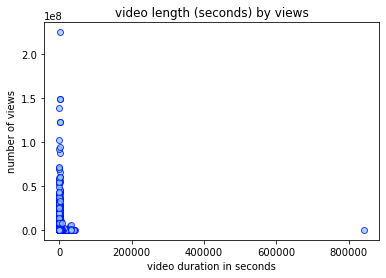

<Figure size 7200x7200 with 0 Axes>

In [40]:
# Creating a scatter plot of video duration and number of views
x_axis = unique_video_id_duration['duration_seconds']
data = unique_video_id_duration['views']
plt.scatter(x_axis, data, marker="o", facecolors="lightskyblue", edgecolors="blue", alpha=0.75)
plt.ylim()
plt.xlim()
plt.xlabel("video duration in seconds")
plt.ylabel("number of views")
plt.title("video length (seconds) by views")
plt.figure(figsize=(100,100));
correlation = st.pearsonr(x_axis, data)
print(f"The correlation between both factors is {round(correlation[0],2)}")

In [15]:
# All unique videos - Computing quantiles for video duration in seconds - for all unique videos youtube had a duration for (some did not return a duration as video could no longer be found)
duration_unique_videos = unique_video_id_duration['duration_seconds']

quartiles = duration_unique_videos.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

# Printing out the relevant information
print(f"The lower quartile is: {lowerq:.2f}")
print(f"The upper quartile is: {upperq:.2f}")
print(f"The interquartile  is: {iqr:.2f}")
print(f"The the median is: {quartiles[0.5]:.2f} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound:.2f} could be outliers.")
print(f"Values above {upper_bound:.2f} could be outliers.")
print()

The lower quartile is: 166.00
The upper quartile is: 545.00
The interquartile  is: 379.00
The the median is: 283.00 
Values below -402.50 could be outliers.
Values above 1113.50 could be outliers.



In [30]:
duration_unique_videos.shape

(5797,)

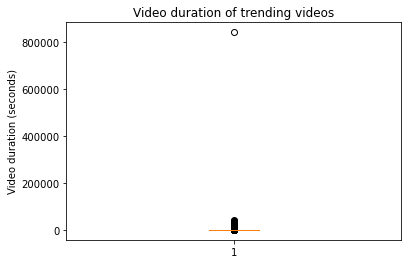

In [16]:
# All unqiue videos - Box plot of video duration (in seconds)
duration_unique_videos = unique_video_id_duration['duration_seconds']

fig1, ax1 = plt.subplots()
ax1.set_title('Video duration of trending videos')
ax1.set_ylabel('Video duration (seconds)')
ax1.boxplot(duration_unique_videos)
plt.show()

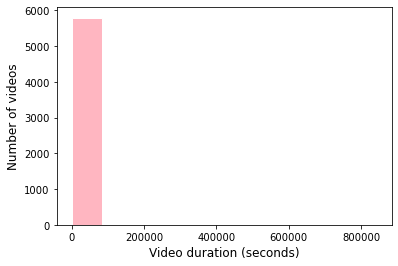

In [17]:
# All unqiue videos - Histogram of video duration in seconds
duration_unique_videos = unique_video_id_duration['duration_seconds']
plt.hist(duration_unique_videos, color='lightpink', edgecolor='white')
plt.xlabel('Video duration (seconds)', fontsize=12)
plt.ylabel('Number of videos', fontsize=12)
plt.show()

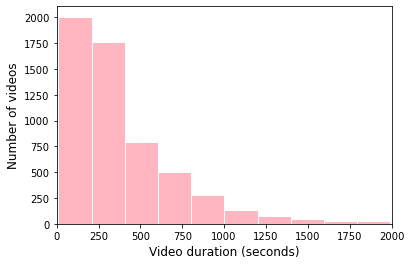

<Figure size 432x288 with 0 Axes>

In [41]:
# All unique videos -  Histogram of video duration in seconds - remvoing those that have a duration greater than 2,000 seconds so that we can see the histogram in more detail
video_duration_filtered = unique_video_id_duration.loc[unique_video_id_duration['duration_seconds'] <2000]
video_duration_filtered =video_duration_filtered['duration_seconds']
plt.hist(video_duration_filtered, color='lightpink', edgecolor='white')
plt.xlabel('Video duration (seconds)', fontsize=12)
plt.ylabel('Number of videos', fontsize=12)
plt.xlim([0,2000])
plt.show()

# Save image to output folder
plt.savefig('output/hist_video_duration.png')

In [42]:
video_duration_filtered.shape

(5635,)

In [43]:
# Calculating quartiles for all categories
category_list = unique_video_id_duration['category_name'].unique()
video_duration_data = []

for name in category_list:
    duration_data = unique_video_id_duration.loc[unique_video_id_duration["category_name"] == name, "duration_seconds"]
    video_duration_data.append(duration_data)
    
    # Using pandas for the quartile calculations
    quartiles = duration_data.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    # Printing out the relevant information
    print(f"The lower quartile of {name} is: {lowerq:.2f}")
    print(f"The upper quartile of {name} is: {upperq:.2f}")
    print(f"The interquartile range of {name} is: {iqr:.2f}")
    print(f"The the median of {name} is: {quartiles[0.5]:.2f} ")

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound:.2f} could be outliers.")
    print(f"Values above {upper_bound:.2f} could be outliers.")
    print()

The lower quartile of Entertainment is: 146.00
The upper quartile of Entertainment is: 571.75
The interquartile range of Entertainment is: 425.75
The the median of Entertainment is: 328.00 
Values below -492.62 could be outliers.
Values above 1210.38 could be outliers.

The lower quartile of Comedy is: 181.00
The upper quartile of Comedy is: 389.00
The interquartile range of Comedy is: 208.00
The the median of Comedy is: 272.00 
Values below -131.00 could be outliers.
Values above 701.00 could be outliers.

The lower quartile of People & Blogs is: 192.75
The upper quartile of People & Blogs is: 665.25
The interquartile range of People & Blogs is: 472.50
The the median of People & Blogs is: 383.00 
Values below -516.00 could be outliers.
Values above 1374.00 could be outliers.

The lower quartile of Education is: 235.50
The upper quartile of Education is: 585.75
The interquartile range of Education is: 350.25
The the median of Education is: 332.00 
Values below -289.88 could be outliers

            category_name  median_duration_seconds
11         Pets & Animals                    157.0
8         News & Politics                    194.0
4        Film & Animation                    202.0
14        Travel & Events                    206.0
5                  Gaming                    211.0
7                   Music                    222.0
9   Nonprofits & Activism                    239.0
13                 Sports                    256.0
0        Autos & Vehicles                    266.0
1                  Comedy                    272.0
3           Entertainment                    328.0
2               Education                    332.0
10         People & Blogs                    383.0
12   Science & Technology                    440.0
6           Howto & Style                    605.0


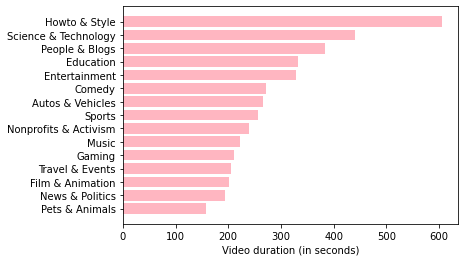

<Figure size 432x288 with 0 Axes>

In [45]:
## Calculating and charting median video duration for all categories in a bar plot ##

# Getting the median video duration in seconds for each category
median_video_duration = unique_video_id_duration.groupby('category_name').median()['duration_seconds']

# Saving it to a dataframe and changing the name of a column
df_median_video_duration = pd.DataFrame(median_video_duration)
df_median_video_duration.reset_index(inplace=True)
df_median_video_duration.rename(columns = {'duration_seconds':'median_duration_seconds'}, inplace=True)


# Sorting values in ascending order of median video duration
category_median_video_duration = df_median_video_duration.sort_values('median_duration_seconds', ascending=True)
print(category_median_video_duration)

# Charting the bar plot
x_axis = category_median_video_duration['category_name']
counts = category_median_video_duration['median_duration_seconds']
plt.barh(x_axis, counts, color="lightpink", align="center")
plt.xlabel('Video duration (in seconds)')
plt.show()

# Save image to output folder
plt.savefig('output/barh_median_video_duration.png')

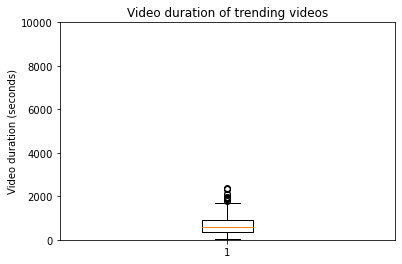

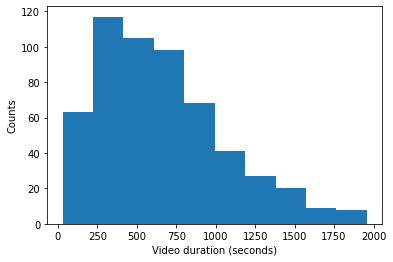

In [21]:
### Howto & Style analysis ###

# Box plot of video duration (in seconds)
howtostyle_videos = unique_video_id_duration.loc[unique_video_id_duration['category_name'] == 'Howto & Style']
howtostyle_duration = howtostyle_videos['duration_seconds']
fig1, ax1 = plt.subplots()
ax1.set_title('Video duration of trending videos')
ax1.set_ylabel('Video duration (seconds)')
plt.ylim(0,10000)
ax1.boxplot(howtostyle_duration)
plt.show()

# Histogram of video duration in seconds
howtostyle_videos_filtered = unique_video_id_duration.loc[(unique_video_id_duration['category_name'] == 'Howto & Style') & (unique_video_id_duration['duration_seconds'] <2000)]
howtostyle_video_filtered = howtostyle_videos_filtered['duration_seconds']
plt.hist(howtostyle_video_filtered)
plt.xlabel('Video duration (seconds)')
plt.ylabel('Counts')
plt.show()

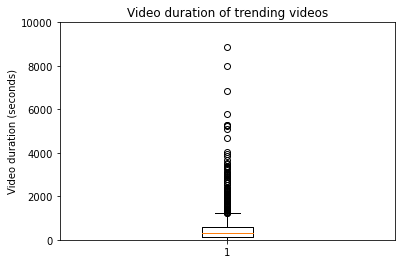

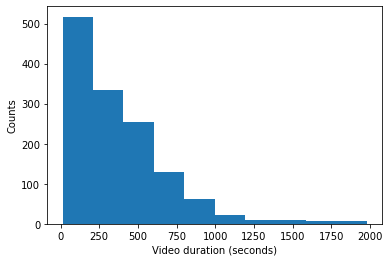

In [22]:
### Entertainment analysis ###

# Box plot of video duration (in seconds)
entertainment_videos = unique_video_id_duration.loc[unique_video_id_duration['category_name'] == 'Entertainment']
entertainment_duration = entertainment_videos['duration_seconds']
fig1, ax1 = plt.subplots()
ax1.set_title('Video duration of trending videos')
ax1.set_ylabel('Video duration (seconds)')
plt.ylim(0,10000)
ax1.boxplot(entertainment_duration)
plt.show()

# Histogram of video duration in seconds
entertainment_videos_filtered = unique_video_id_duration.loc[(unique_video_id_duration['category_name'] == 'Entertainment') & (unique_video_id_duration['duration_seconds'] <2000)]
entertainment_video_filtered = entertainment_videos_filtered['duration_seconds']
plt.hist(entertainment_video_filtered)
plt.xlabel('Video duration (seconds)')
plt.ylabel('Counts')
plt.show()